In [7]:
%matplotlib inline
from torchvision import datasets
import PIL
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [4]:
import skimage
print(skimage.__version__)

0.18.3


In [8]:
trainDset = datasets.CIFAR10('./cifar10/', train=True, download=True)
testDset = datasets.CIFAR10('./cifar10/', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [9]:
print('No. of samples in train test: '+str(len(trainDset)))
print('No. of samples in train test: '+str(len(testDset)))

No. of samples in train test: 50000
No. of samples in train test: 10000


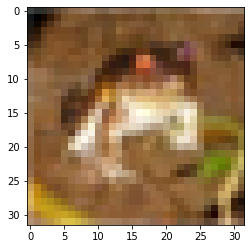

In [19]:
img = trainDset[0][0]
img_gray = img.convert('L')
img_arr = np.array(img_gray)
plt.imshow(img)

**LOCAL BINARY PATTERNS-(LBP)**

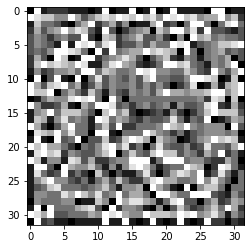

In [22]:
#Finding the LBP
feat_lbp =local_binary_pattern(img_arr,8,1,'uniform')
feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255)
lbp_img =PIL.Image.fromarray(feat_lbp)
plt.imshow(lbp_img,cmap='gray')

In [23]:
# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))

LBP energy = 0.14315032958984375
LBP entropy = 2.8972505530220363


**Co-occurance matrix**

In [24]:
# Finding GLCM features from co-occurance matrix
gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
print('Contrast = '+str(contrast[0][0]))
print('Dissimilarity = '+str(dissimilarity[0][0]))
print('Homogeneity = '+str(homogeneity[0][0]))
print('Energy = '+str(energy[0][0]))
print('Correlation = '+str(correlation[0][0]))

Contrast = 1296.8916666666667
Dissimilarity = 24.225
Homogeneity = 0.06323755700795276
Energy = 0.027282918445226654
Correlation = 0.6119618429581918


**Gabor filter**

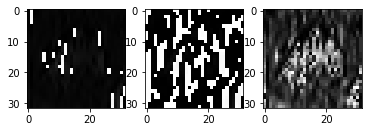

In [25]:
# Gabor filter
gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gaborFilt_real,cmap='gray')
ax[1].imshow(gaborFilt_imag,cmap='gray')
ax[2].imshow(gaborFilt,cmap='gray')

In [26]:
# Energy and Entropy of Gabor filter response
gabor_hist,_ = np.histogram(gaborFilt,8)
gabor_hist = np.array(gabor_hist,dtype=float)
gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
gabor_energy = np.sum(gabor_prob**2)
gabor_entropy = -np.sum(np.multiply(gabor_prob,np.log2(gabor_prob)))
print('Gabor energy = '+str(gabor_energy))
print('Gabor entropy = '+str(gabor_entropy))

Gabor energy = 0.24701309204101562
Gabor entropy = 2.3533467655293547


**Extracting features from all images in the dataset**

In [30]:
# Generating training data by extracting features from all images
from tqdm import tqdm_notebook
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(trainDset),featLength)) #Feature vector of each image is of size 1x1030
for tr in tqdm_notebook(range(len(trainDset))):

    img = trainDset[tr][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(trainDset[tr][1])
trainLabel = np.array(label) #Conversion from list to array

<ipython-input-30-a87b8031fed7>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tr in tqdm_notebook(range(len(trainDset))):


  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-30-a87b8031fed7>:17: RuntimeWarning: divide by zero encountered in log2
  lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
<ipython-input-30-a87b8031fed7>:17: RuntimeWarning: invalid value encountered in multiply
  lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
<ipython-input-30-a87b8031fed7>:33: RuntimeWarning: divide by zero encountered in log2
  gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
<ipython-input-30-a87b8031fed7>:33: RuntimeWarning: invalid value encountered in multiply
  gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))


In [31]:
# Generating testing data by extracting features from all images
label = []
testFeats = np.zeros((len(testDset),featLength)) #Feature vector of each image is of size 1x1030
for ts in tqdm_notebook(range(len(testDset))):
    
    img = testDset[ts][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)    
    testFeats[ts,:] = concat_feat  #Stacking features vectors for each image
    # Class label
    label.append(testDset[ts][1])
testLabel = np.array(label)

<ipython-input-31-463b5f19036d>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ts in tqdm_notebook(range(len(testDset))):


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-31-463b5f19036d>:15: RuntimeWarning: divide by zero encountered in log2
  lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
<ipython-input-31-463b5f19036d>:15: RuntimeWarning: invalid value encountered in multiply
  lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
<ipython-input-31-463b5f19036d>:31: RuntimeWarning: divide by zero encountered in log2
  gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
<ipython-input-31-463b5f19036d>:31: RuntimeWarning: invalid value encountered in multiply
  gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))


**Feature normalization**

In [32]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(50000,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(50000,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

In [33]:
# Saving normalized training data and labels
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

Files saved to disk!
